In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from mcmc_optimization import optimize_via_mcmc
from models import LinearLayer
from data_samplers import BatchSampler
from proposal_generators import LinearLayerNormalProposalGenerator

## Pure interpolation

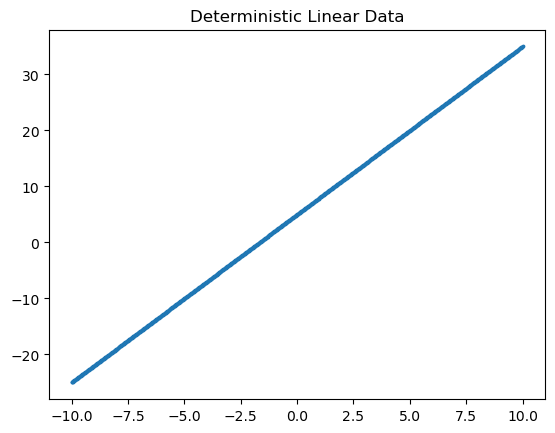

In [2]:
# Generate data.

true_function = lambda x: 3*x+5
len_data = 1000
x_vals = np.linspace(-10,10,len_data)
y_vals = true_function(x_vals)

plt.title("Deterministic Linear Data")
plt.scatter(x_vals, y_vals, s=3)
plt.show()

In the example below we use a Gaussian random walk for our proposal Markov Chain.

In [3]:
initial_params = {'w': 0.2, 'b': 6}
data_sampler = BatchSampler(X=x_vals, y=y_vals)
proposal_generator = LinearLayerNormalProposalGenerator(stdev=1.1)

best_params, history = optimize_via_mcmc(LinearLayer, initial_params, data_sampler, proposal_generator, mean_squared_error)

In [4]:
print(f"Proportion of proposals accepted: {history['acceptance_ratio']:.4f}")
print(f"Best parameters found: w={best_params['w']}, b={best_params['b']}")
print(f"Best achieved loss: {min(history['loss_values']):.4f}")

Proportion of proposals accepted: 0.1576
Best parameters found: w=3.0051365906647365, b=5.000159390963759
Best achieved loss: 0.0007


The rest of this is junk with the current setup. Will fix.

In [50]:
parameter_values = np.vstack(parameter_values)

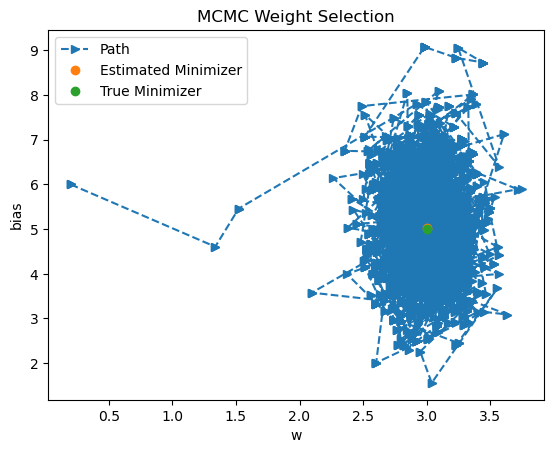

In [51]:
plt.plot(parameter_values[:,0], parameter_values[:,1],'-->',label="Path")
plt.plot(best_w, best_b,'o',label="Estimated Minimizer")
plt.plot([3],[5],'o',label="True Minimizer")
plt.xlabel("w")
plt.ylabel("bias")
plt.legend()
plt.title("MCMC Weight Selection")
plt.show()

## Noisy regression (univariate contrived)

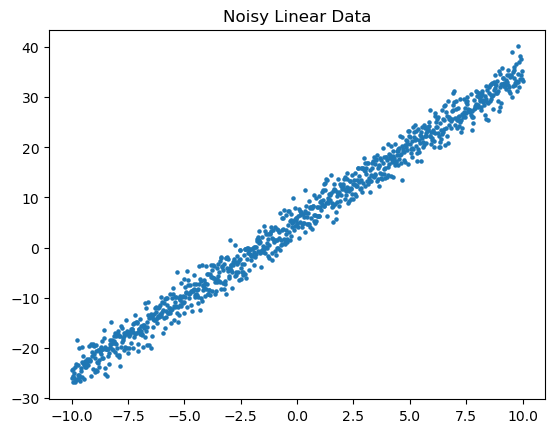

In [80]:
# Generate data.

true_function = lambda x: 3*x+5
len_data = 1000
x_vals = np.linspace(-10,10,len_data)
y_vals = true_function(x_vals) + np.random.normal(scale=2, size=len(x_vals))

plt.title("Noisy Linear Data")
plt.scatter(x_vals, y_vals, s=5)
plt.show()

In [81]:
# Fit linear regression model the standard way.

from sklearn.linear_model import LinearRegression

ground_truth_linear = LinearRegression().fit(x_vals.reshape(-1, 1), y_vals)

ground_truth_linear.coef_, ground_truth_linear.intercept_

(array([3.01304461]), 5.0354166807166285)

In [82]:
model = LinearLayer(w=0.2, b=6)
beta = 0.5  # Hyperparameter for MCMC acceptance probabilities.
loss_function = mean_squared_error

parameter_values = [(model.w, model.b)]
num_accepted = 0
num_iterations = 10000

min_achieved_loss = np.inf
best_w, best_b = None, None

for i in range(num_iterations):

    # Get random subset from data.
    x_sample, y_sample = get_random_sample(x_vals, y_vals, size=25)

    # Get proposal weights.
    proposed_w = np.random.normal(loc=model.w, scale=1.1)
    proposed_b = np.random.normal(loc=model.b, scale=1.1)
    proposed_model = LinearLayer(proposed_w, proposed_b)

    # Decide whether/not to accept proposed weights.
    proposal_loss = compute_loss(proposed_model, loss_function, x_sample, y_sample)
    current_loss = compute_loss(model, loss_function, x_sample, y_sample)
    acceptance_probability = np.exp(-beta * (proposal_loss - current_loss))
    accept = np.random.rand() <= acceptance_probability

    if accept:
        if proposal_loss < min_achieved_loss:
            min_achieved_loss = proposal_loss
            best_w, best_b = proposed_w, proposed_b

        num_accepted += 1
        model = proposed_model
    
    parameter_values.append((model.w, model.b))

print(f"Iterations run: {num_iterations}")
print(f"Proportion of proposals accepted: {num_accepted / num_iterations:.4f}")
print(f"Best parameters found: w={best_w}, b={best_b}")
print(f"Best achieved loss: {min_achieved_loss}")

Iterations run: 10000
Proportion of proposals accepted: 0.1709
Best parameters found: w=2.9881170035194637, b=4.79927972601117
Best achieved loss: 1.546568450464828


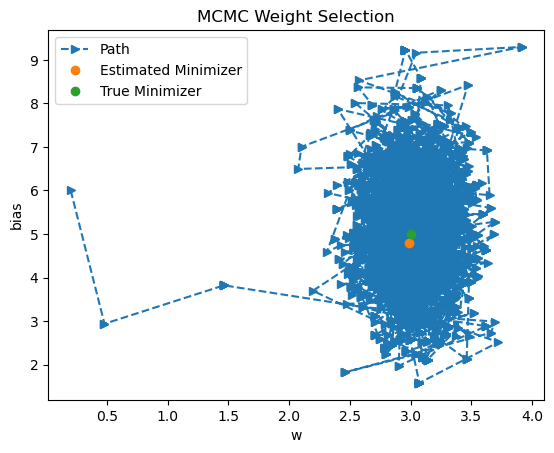

In [83]:
parameter_values = np.row_stack(parameter_values)

plt.plot(parameter_values[:,0], parameter_values[:,1],'-->',label="Path")
plt.plot(best_w, best_b,'o',label="Estimated Minimizer")
plt.plot([3],[5],'o',label="True Minimizer")
plt.xlabel("w")
plt.ylabel("bias")
plt.legend()
plt.title("MCMC Weight Selection")
plt.show()

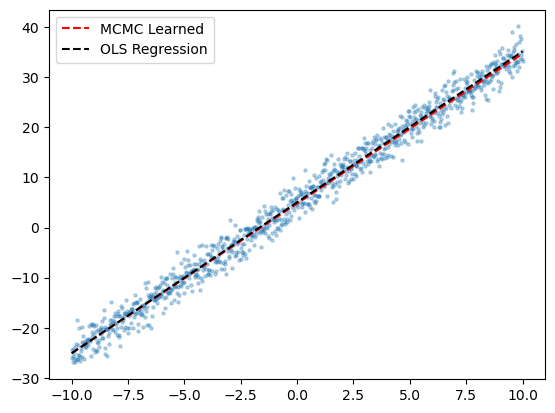

In [89]:
# Plot linear regression against MCMC method.

plt.scatter(x_vals, y_vals, s=5, alpha=0.3)
plt.plot(x_vals, best_w * x_vals + best_b, '--', label="MCMC Learned", c='r')
plt.plot(x_vals, ground_truth_linear.predict(x_vals.reshape(-1, 1)), '--', label="OLS Regression", c='k')

plt.legend()
plt.show()

## Real-life linear regression (multivariate)



In [92]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15480, 8), (5160, 8), (15480,), (5160,))

In [96]:
ground_truth_linear = LinearRegression().fit(X_train, y_train)
actual_w, actual_b = ground_truth_linear.coef_, ground_truth_linear.intercept_

print(f"w = {np.round(actual_w, 3)}\n b = {actual_b}")

w = [ 0.432  0.009 -0.097  0.589 -0.    -0.004 -0.423 -0.437]
 b = -37.12590169052402


In [117]:
mean_squared_error(y_train, ground_truth_linear.predict(X_train))

0.5315475914577896

In [ ]:
from scipy.stats import multivariate_normal as mv_norm

initial_w = np.random.normal(size=X_train.shape[1])
initial_b = np.random.uniform(-30, 30)

model = LinearLayer(initial_w, initial_b)
beta = 1e-4  # Hyperparameter for MCMC acceptance probabilities.
loss_function = mean_squared_error

parameter_values = [(model.w, model.b)]
num_accepted = 0
num_iterations = 100000

min_achieved_loss = np.inf
best_w, best_b = None, None

for i in range(num_iterations):

    # Get random subset from data.
    x_sample, y_sample = get_random_sample(X_train, y_train, size=150)

    # Get proposal weights.
    proposed_w = mv_norm.rvs(mean=model.w, cov=1.1)
    proposed_b = np.random.normal(loc=model.b, scale=0.5)
    proposed_model = LinearLayer(proposed_w, proposed_b)

    # Decide whether/not to accept proposed weights.
    proposal_loss = compute_loss(proposed_model, loss_function, x_sample, y_sample)
    current_loss = compute_loss(model, loss_function, x_sample, y_sample)
    acceptance_probability = np.exp(-beta * (proposal_loss - current_loss))
    accept = np.random.rand() <= acceptance_probability

    if accept:
        if proposal_loss < min_achieved_loss:
            min_achieved_loss = proposal_loss
            best_w, best_b = proposed_w, proposed_b

        num_accepted += 1
        model = proposed_model
    
    parameter_values.append((model.w, model.b))

In [134]:
print(f"Iterations run: {num_iterations}")
print(f"Proportion of proposals accepted: {num_accepted / num_iterations:.4f}")
print(f"Best parameters found:\n\tw = {np.round(best_w, 2)}\n\tb = {best_b:.4f}")
print(f"Best achieved training loss: {min_achieved_loss}")

Iterations run: 100000
Proportion of proposals accepted: 0.0435
Best parameters found:
	w = [-6.51 -0.28 11.59 26.12 -0.   -9.06  5.99  2.18]
	b = 40.0567
Best achieved training loss: 708.3391115480044


In [135]:
best_model = LinearLayer(best_w, best_b)

mean_squared_error(y_test, best_model.forward(X_test))

8108.459158751845

It looks like our weights are spiraling out of control. There needs to be some sort of mechanism stopping them from growing too large.

In [194]:
# Trying regularization for optimizer search.

from scipy.stats import multivariate_normal as mv_norm

initial_w = np.random.normal(size=X_train.shape[1])
initial_b = np.random.uniform(-30, 30)

model = LinearLayer(initial_w, initial_b)
beta = 1e-4  # Hyperparameter for MCMC acceptance probabilities.
loss_function = mean_squared_error

num_accepted = 0
num_iterations = 50000
initial_covariance = 50
initial_bias_variance = 30

parameter_values = np.zeros((num_iterations, X_train.shape[1] + 1))
parameter_values[0, :-1] = initial_w
parameter_values[0, -1] = initial_b
min_achieved_loss = np.inf
best_w, best_b = None, None
decay_factor = 1

for i in range(num_iterations):

    # Get random subset from data.
    x_sample, y_sample = get_random_sample(X_train, y_train, size=150)

    # Get proposal weights.
    proposed_w = mv_norm.rvs(mean=model.w, cov=initial_covariance / (0.3*i + 1))
    proposed_b = np.random.normal(loc=model.b, scale=initial_bias_variance / (0.3*i + 1))
    proposed_model = LinearLayer(proposed_w, proposed_b)

    # Decide whether/not to accept proposed weights.
    proposal_loss = compute_loss(proposed_model, loss_function, x_sample, y_sample, alpha=2)
    current_loss = compute_loss(model, loss_function, x_sample, y_sample, alpha=2)
    acceptance_probability = np.exp(-beta * (proposal_loss - current_loss))
    accept = np.random.rand() <= acceptance_probability

    if accept:
        if proposal_loss < min_achieved_loss:
            min_achieved_loss = proposal_loss
            best_w, best_b = proposed_w, proposed_b

        num_accepted += 1
        model = proposed_model
    
    parameter_values[i, :-1] = model.w
    parameter_values[i, -1] = model.b

print(f"Iterations run: {num_iterations}")
print(f"Proportion of proposals accepted: {num_accepted / num_iterations:.4f}")
print(f"Best parameters found:\n\tw = {np.round(best_w, 2)}\n\tb = {best_b:.4f}")
print(f"Best achieved training loss: {min_achieved_loss}")

Iterations run: 50000
Proportion of proposals accepted: 0.4609
Best parameters found:
	w = [ 4.690e+00 -2.400e-01 -3.580e+01  3.213e+01  2.000e-02  3.017e+01
  3.280e+00  7.000e-01]
	b = 2.7009
Best achieved training loss: 2111.8399789664627


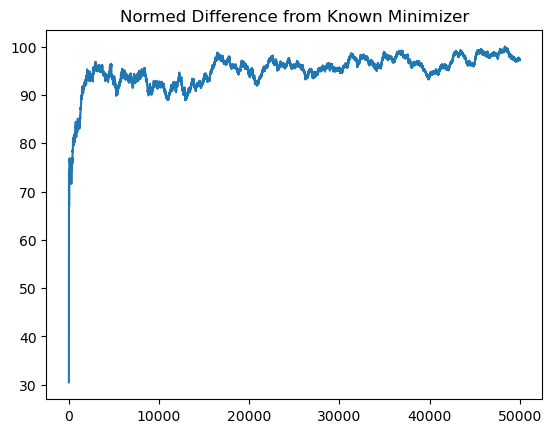

In [195]:
plt.title("Normed Difference from Known Minimizer")
plt.plot((np.linalg.norm(parameter_values[:, :8] - actual_w, axis=1) + np.abs(parameter_values[:, -1] - actual_b)))
plt.show()

In linear regression, at least, we are not approaching the optimizer with this method.